In [1]:
from os import listdir, makedirs
from os.path import join

import numpy as np
import pandas as pd

# from tqdm import tqdm_notebook

import tensorflow as tf

import keras
from keras.engine.input_layer import Input

import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model, to_categorical

from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv1D, BatchNormalization

from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(1)


Using TensorFlow backend.


In [2]:
data = pd.read_csv("../train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

In [3]:
x = data[:,0]
y = data[:, 1]

In [4]:
x.shape

(629145480,)

In [5]:
y.shape

(629145480,)

In [6]:
def x_ave_pooling(x_s, y_s, step_size=5):
    # pooling a single data point to 1/10 of the original length
    n = len(x_s)//step_size 
    
    x_temp = x_s[0:n*step_size].reshape(-1, step_size)
    x_ave = np.mean(x_temp, axis=1)
    return x_ave

In [7]:
def get_data(x, y, seq_length=150000, step_size=5, data_spread=10000):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    n_data = len(x)//data_spread
    
    ## TODO: Get the number of batches we can make
    
    x_data = []
    y_data = []
    
    for n in range(n_data-14):

        x_temp = x[n*data_spread:(n*data_spread + seq_length)]
        y_temp = y[n*data_spread + seq_length-1]
        
        x_ave = x_ave_pooling(x_temp, step_size)
        
        x_data.append(x_ave)
        y_data.append(y_temp)
    return np.array(x_data), np.array(y_data) 

In [8]:
x_data, y_data = get_data(x, y, seq_length=150000, step_size=5)

In [9]:
x_data.shape

(62900, 30000)

In [10]:
y_data.shape

(62900,)

In [11]:
x_data_exp = np.expand_dims(x_data, -1)

In [12]:
x_data_exp.shape

(62900, 30000, 1)

In [13]:
y_data_exp= y_data.reshape(-1, 1)

In [14]:
y_data_exp.shape

(62900, 1)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_data_exp, y_data_exp, test_size=0.2, shuffle= True, random_state=38)

In [17]:
from Resnet50Conv1d import identity_block, convolutional_block, ResNet50

In [18]:
keras.backend.clear_session()

model = ResNet50(
    input_shape=(30000, 1), 
    n_out=1)
#model = load_model() 

model.compile(
    loss = "mse",
    optimizer = Adam(lr=0.0001),
    metrics=['mae'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30000, 1)     0                                            
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 5999, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 6005, 1)      0           max_pooling1d_1[0][0]            
__________________________________________________________________________________________________
conv1 (Conv1D)       

In [19]:
batch_size=64
epochs = 30

# model = load_model('conv1d_length30000_batchNorm3.h5') 

In [20]:
checkpointer = ModelCheckpoint(
    './Resnet50Conv1d_L2_model1_A/weights.{epoch:03d}-{val_loss:.3f}-{val_mean_absolute_error:.3f}.hdf5', 
    verbose=2, 
    save_best_only=True)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                    callbacks=[checkpointer], validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 50320 samples, validate on 12580 samples
Epoch 1/30
50320/50320 [==============================] - 82s 2ms/step - loss: 58.1044 - mean_absolute_error: 3.5976 - val_loss: 8.3288 - val_mean_absolute_error: 2.2151

Epoch 00001: val_loss improved from inf to 8.32877, saving model to ./Resnet50Conv1d_L2_model1_A/weights.001-8.329-2.215.hdf5
Epoch 2/30
50320/50320 [==============================] - 77s 2ms/step - loss: 8.9881 - mean_absolute_error: 2.3134 - val_loss: 7.9447 - val_mean_absolute_error: 2.1996

Epoch 00002: val_loss improved from 8.32877 to 7.94468, saving model to ./Resnet50Conv1d_L2_model1_A/weights.002-7.945-2.200.hdf5
Epoch 3/30
50320/50320 [==============================] - 77s 2ms/step - loss: 8.4431 - mean_absolute_error: 2.2320 - val_loss: 8.7059 - val_mean_absolute_error: 2.1743

Epoch 00003: val_loss did not improve from 7.94468
Epoch 4/30
50320/50320 [==============================] - 76s 2ms/step - loss: 8.293

Epoch 30/30
50320/50320 [==============================] - 77s 2ms/step - loss: 1.2790 - mean_absolute_error: 0.8444 - val_loss: 1.3087 - val_mean_absolute_error: 0.8613

Epoch 00030: val_loss did not improve from 1.17794


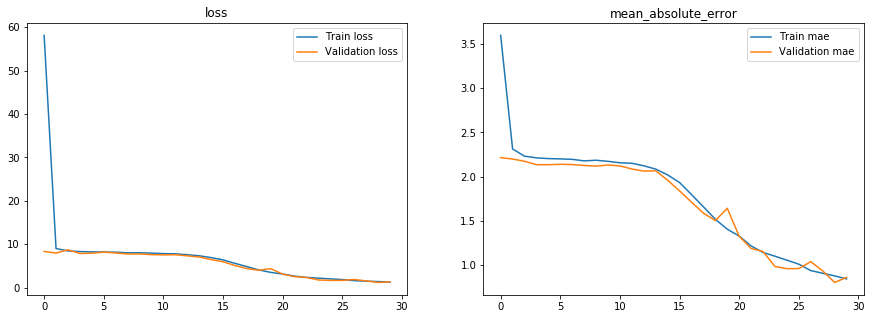

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('mean_absolute_error')
ax[1].plot(history.epoch, history.history["mean_absolute_error"], label="Train mae")
ax[1].plot(history.epoch, history.history["val_mean_absolute_error"], label="Validation mae")
ax[0].legend()
ax[1].legend()

In [22]:
hist_df = pd.DataFrame(history.history) 

In [26]:
hist_csv_file = './Resnet50Conv1d_L2_model1_A/weights.029-1.178-0.804_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f, index=False)

In [27]:
df_1 = pd.read_csv('./Resnet50Conv1d_L2_model1_A/weights.029-1.178-0.804_history.csv')
df_1.head()

,val_loss,val_mean_absolute_error,loss,mean_absolute_error
0,8.328771281886746535860766016413,2.215086542593466489847742195707,58.104443138013394332119787577540,3.597627992432901766761688122642
1,7.944681794389442330839301575907,2.199572227186921580255329899956,8.988114432500161399275384610519,2.313436588081154265950090120896
2,8.705866491927251260563025425654,2.174321154608067185876052462845,8.443056220280537260691744450014,2.231954935965364317240755553939
3,7.854836655269555656389002251672,2.135493017721251884921684904839,8.293865335309828168419699068181,2.212810104715805081809776311275
4,7.912657871155366784421403281158,2.135584006210957674909423076315,8.226846895384674951401393627748,2.204607423955192491149546185625


In [28]:
load_model = load_model('./Resnet50Conv1d_L2_model1_A/weights.029-1.178-0.804.hdf5') 

In [29]:
def ave_pooling_x(x_s, step_size=5):
    # pooling a single data point to 1/10 of the original length
    n = len(x_s)//step_size 
    
    x_temp = x_s[0:n*step_size].reshape(-1, step_size)    
    x_ave = np.mean(x_temp, axis=1)    
    return x_ave

In [30]:
x = pd.read_csv('../test/' + "seg_27de37.csv")
x = x['acoustic_data'].values

In [31]:
def predict_resnet(x, load_model, step_size=5):
    
        arr_x = ave_pooling_x(x, step_size)
        arr_x = np.expand_dims(arr_x, 1)
        arr_x = np.expand_dims(arr_x, 0)
        y_pred = load_model.predict(arr_x, batch_size=None, verbose=0, steps=None)
        return y_pred

In [33]:
# Load submission file
submission = pd.read_csv('../sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

In [34]:
# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(submission.index):
  #  print(i)
    seg = pd.read_csv('../test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    y = predict_resnet(x, load_model)
    submission.time_to_failure[i] = y[-1,0].item()

submission.head()

,time_to_failure
seg_id,
seg_00030f,9.268905639648437500000
seg_0012b5,4.291700363159179687500
seg_00184e,6.128233909606933593750
seg_003339,7.477239131927490234375
seg_0042cc,5.315472602844238281250


In [35]:
submission.tail()

,time_to_failure
seg_id,
seg_ff4236,3.2771511077880859375000
seg_ff7478,6.4921026229858398437500
seg_ff79d9,2.5247814655303955078125
seg_ffbd6a,7.1502723693847656250000
seg_ffe7cc,6.2811017036437988281250


In [36]:
submission.to_csv('./Resnet50Conv1d_L2_model1_A/Resnet50_test.csv')